# **Stock Price Prediction And Forecasting Using LSTM- Deep Learning**

In [ ]:
import pandas as pd
%matplotlib inline
import numpy as np
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
df = yf.download(tickers = "^GSPC", start = "2013-01-01", end = "2024-02-10", interval = "1d")['Close']

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df = df.reset_index()['Close']

Scale Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

Split into train and test data

In [ ]:
training_size = int(len(df) * 0.75)
validation_size = int(len(df) * 0.15)
test_size = len(df) - training_size - validation_size

train_data = df[0:training_size, :]
validation_data = df[training_size:training_size+validation_size, :]
test_data = df[training_size+validation_size:len(df), :]

In [ ]:
train_data.shape, validation_data.shape , test_data.shape

((2097, 1), (419, 1), (280, 1))

Create feature data

In [ ]:
def process_data(data,time_step=1):
    xtrain,ytrain =[],[]
    for i in range(len(data)-time_step-1):
        xtrain.append(data[i:(i+time_step),0])
        ytrain.append(data[i+time_step,0])
    return np.array(xtrain),np.array(ytrain)

In [ ]:
xtrain,ytrain = process_data(train_data,50)
xval,yval = process_data(validation_data,50)
xtest,ytest = process_data(test_data,50)

In [ ]:
xtrain.shape,xval.shape

((2046, 50), (368, 50))

In [ ]:
xtest.shape,ytest.shape

((229, 50), (229,))

# reshape input to be [samples, time steps, features] which is required for LSTM

In [ ]:
X_train = xtrain.reshape(xtrain.shape[0],xtrain.shape[1],1)
X_test = xtest.reshape(xtest.shape[0],xtest.shape[1],1)
X_val = xval.reshape(xval.shape[0],xval.shape[1],1)

In [ ]:
X_train.shape,X_test.shape,X_val.shape

((2046, 50, 1), (229, 50, 1), (368, 50, 1))

In [ ]:
model = Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer=Adam())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 50, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 50)                23000     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 140269 (547.93 KB)
Trainable params: 14026

In [ ]:
# plot_model(model,show_shapes =True, show_layer_names=True)

In [ ]:
checkpoint_path = "/content/lstm_12_p50_ckp_13_24_e150.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=False,
                                      monitor="val_loss",
                                      save_best_only=True)

early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 10,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-5)

In [ ]:
history = model.fit(X_train,ytrain,validation_data=(X_val,yval),epochs=150,batch_size=32,verbose=1,
                     callbacks=[ early_stopping,
                                checkpoint_callback])
                    #             reduce_lr])

Epoch 1/150
64/64 [==============================] - 19s 183ms/step - loss: 0.0067 - val_loss: 0.0016
Epoch 2/150
 1/64 [..............................] - ETA: 7s - loss: 5.5496e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 10s 158ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3/150
64/64 [==============================] - 8s 128ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 4/150
64/64 [==============================] - 10s 162ms/step - loss: 9.3372e-04 - val_loss: 0.0026
Epoch 5/150
64/64 [==============================] - 10s 159ms/step - loss: 7.4892e-04 - val_loss: 0.0029
Epoch 6/150
64/64 [==============================] - 9s 136ms/step - loss: 7.3896e-04 - val_loss: 0.0015
Epoch 7/150
64/64 [==============================] - 10s 161ms/step - loss: 6.5489e-04 - val_loss: 0.0013
Epoch 8/150
64/64 [==============================] - 10s 162ms/step - loss: 6.7370e-04 - val_loss: 0.0033
Epoch 9/150
64/64 [==============================] - 12s 182ms/step - loss: 6.1749e-04 - val_loss: 0.0011
Epoch 10/150
64/64 [==============================] - 9s 137ms/step - loss: 5.5219e-04 - val_loss: 0.0010
Epoch 11/150
64/64 [==============================] - 10s 160ms/step

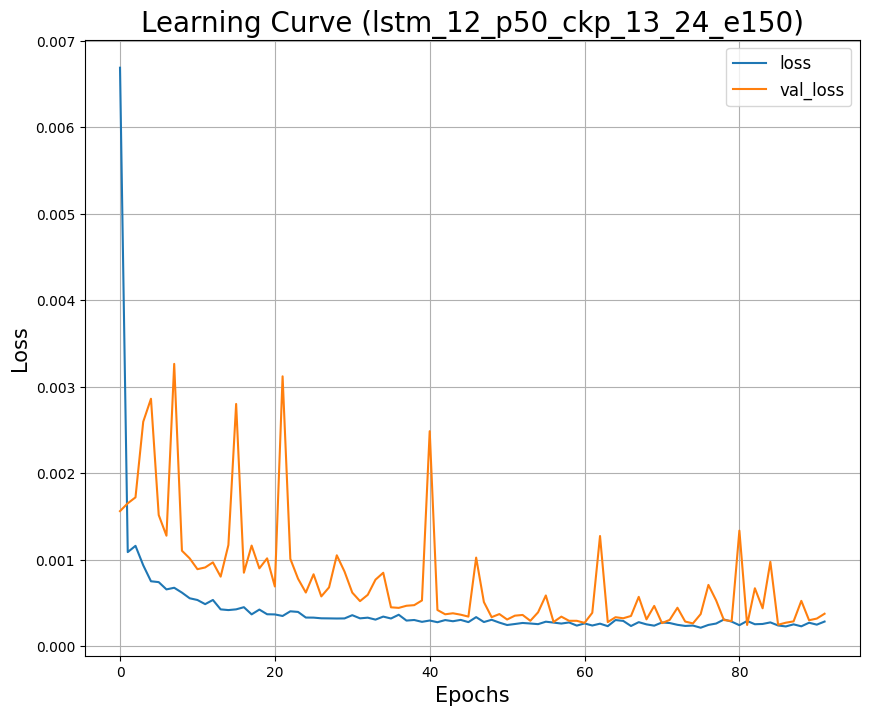

In [ ]:
result = pd.DataFrame(history.history)
result.plot(figsize=(10,8))
plt.title("Learning Curve (lstm_12_p50_ckp_13_24_e150)", fontsize=20)
plt.grid()
plt.legend(fontsize=12)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()


In [ ]:
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

8/8 [==============================] - 0s 37ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
val_predict = scaler.inverse_transform(val_predict)

In [ ]:
math.sqrt(mean_squared_error(ytrain,train_predict))

2523.1148295576954

In [ ]:
math.sqrt(mean_squared_error(ytest,test_predict))

4406.886199345149

In [ ]:
# shift train predictions for plotting
look_back = 50
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# shift validation predictions for plotting
valPredictPlot = np.empty_like(df)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(train_predict) + look_back + 1:len(train_predict) + look_back + len(val_predict) + 1, :] = val_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + len(val_predict) + (look_back * 3) + 1:len(train_predict) + len(val_predict) + (look_back * 3) + len(test_predict) + 1, :] = test_predict


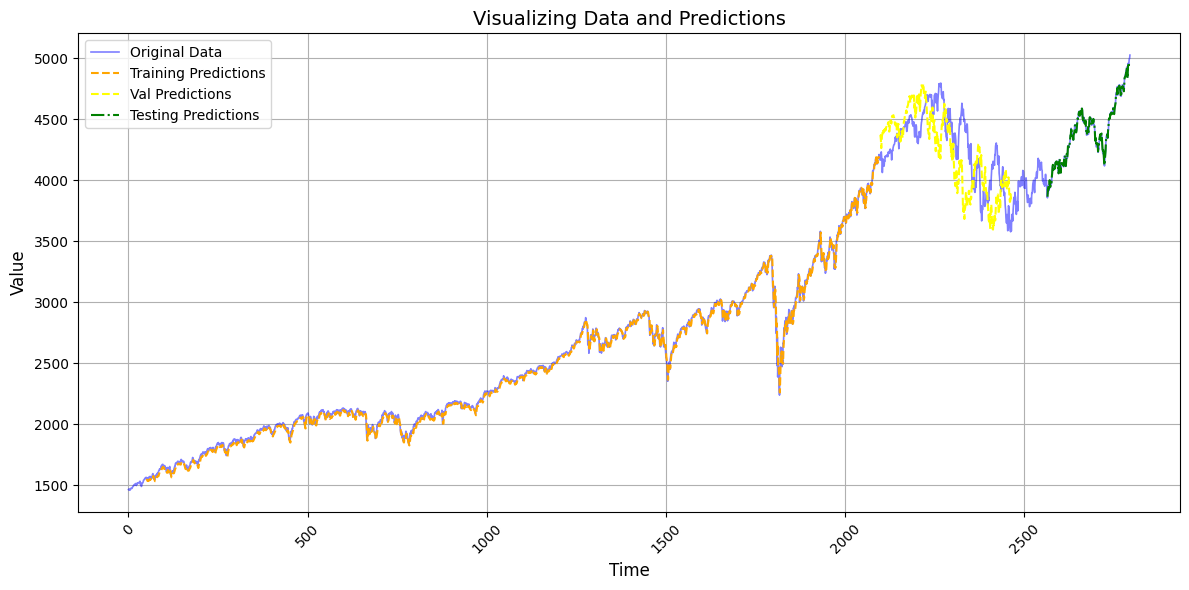

In [ ]:
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(scaler.inverse_transform(df), label='Original Data', color='blue', linewidth=1.2,alpha=0.5)

# Plot training predictions
plt.plot(trainPredictPlot, label='Training Predictions', color='orange', linewidth=1.5, linestyle='--')
plt.plot(valPredictPlot, label='Val Predictions', color='yellow', linewidth=1.5, linestyle='--')
# Plot testing predictions
plt.plot(testPredictPlot, label='Testing Predictions', color='green', linewidth=1.5, linestyle='-.')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Visualizing Data and Predictions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Visualizing Data and Predictions', fontsize=14)
plt.tight_layout()
plt.show()

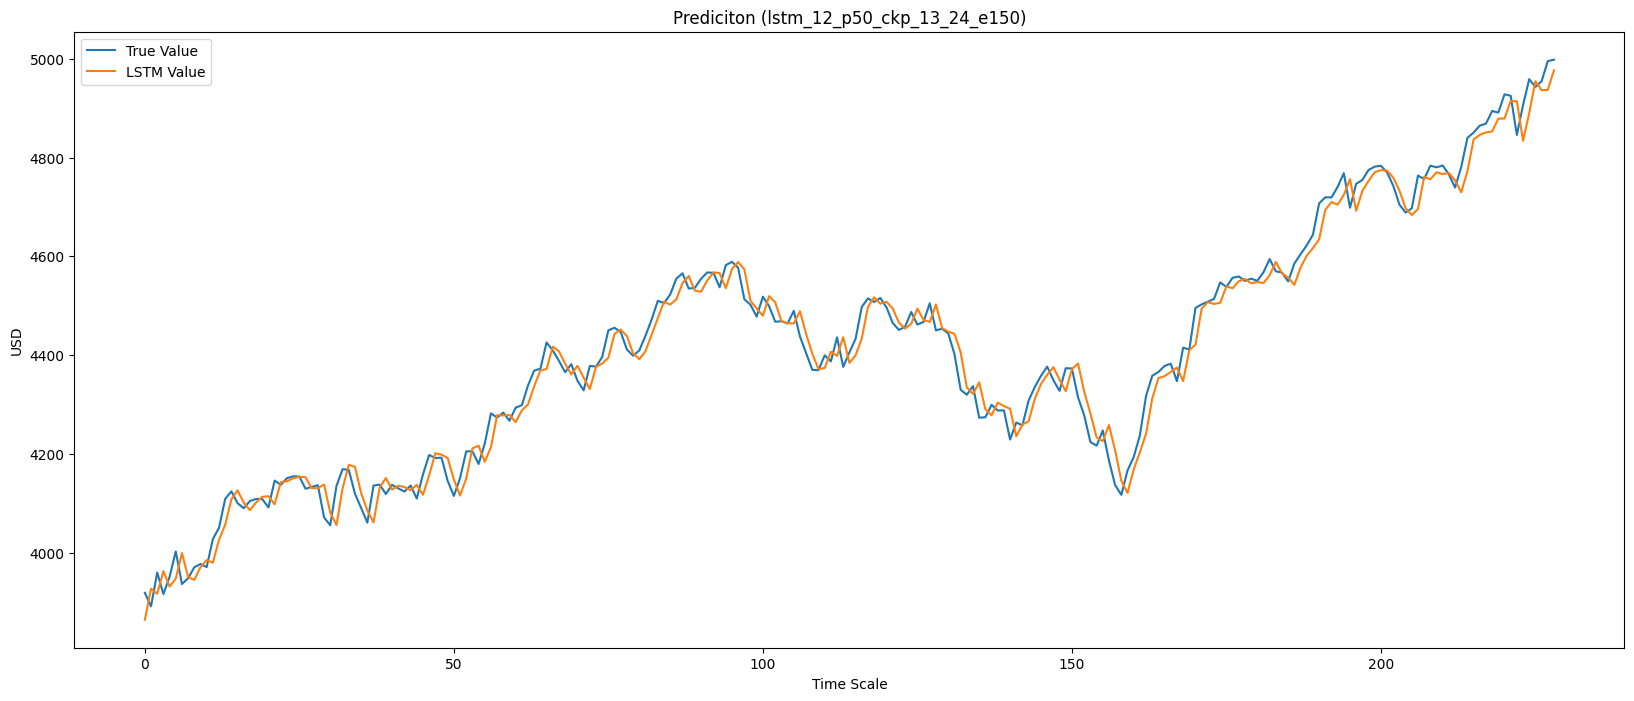

In [ ]:
ytest_inv = scaler.inverse_transform(np.array(ytest).reshape(-1,1))
plt.figure(figsize=(20, 8))
plt.plot(ytest_inv, label="True Value")
plt.plot(test_predict, label="LSTM Value")
plt.title("Prediciton (lstm_12_p50_ckp_13_24_e150)")
plt.xlabel("Time Scale")
plt.ylabel("USD")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import save_model
save_model(model, "lstm_12_p50_ckp_13_24_e150.keras")

In [ ]:
# from keras.models import load_model
# lstm_model = load_model("/content/lstm_12_p50_ckp_13_24_e150.h5")

In [ ]:
# prd = lstm_model.predict(X_test)

### Model Inference time

In [ ]:
import time
single_sample = X_test[:1]
start_time = time.time()
single_prediction = model.predict(single_sample)
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time for single prediction: {inference_time:.6f} seconds")

1/1 [==============================] - 0s 34ms/step
Inference time for single prediction: 0.102722 seconds


10 predictions per second

Tutorial that I learned from [youtube](https://www.youtube.com/watch?v=H6du_pfuznE)